# W207 Group Project: True vs Fake News 
#### Members: Akiko Iwamizu, Allison Fox, Jason Yang, Rohin Chabra

## Project Background

Our goal for this project was to use labeled news datasets to make an algorithm that is able to determine if an article is fake news or real news. To build the model, we used a dataset provided by Kaggle. During the model development process, we explored performance of Logistic, Naive Bayes, and KNN models, along with unigram, bigram, and trigram feature vectors for text representation. To test the generalizability of the model, we then evaluated the model against a second dataset provided by Kaggle.

## Data Background

### Dataset 1
* Provided by Kaggle: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
* Contents: two data sets -- one that includes fake news and one that includes real news
* primary focus of our analysis

### Dataset 2
* Provided by Kaggle: https://www.kaggle.com/c/fake-news/code
* Contents: two data sets -- one that includes train data and one that includes test data
* supplementary dataset to explore generalizability of the models

In [1]:
# Load libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile

import time
import re
import string
import nltk
import unicodedata

from nltk.corpus import stopwords
from textblob import TextBlob

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction import text
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings('ignore')

## Import Dataset 1 

In [2]:
# Read in fake news data file.
fake_zip = zipfile.ZipFile("input/fake-and-real-news-dataset/Fake.csv.zip") 
fake = pd.read_csv(fake_zip.open("Fake.csv"))
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [3]:
# Read in true news data file.
true_zip = zipfile.ZipFile("input/fake-and-real-news-dataset/True.csv.zip") 
true = pd.read_csv(true_zip.open("True.csv"))
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
# Create label columns for the fake news data set.
fake["label"] = "false"
fake["label_bin"] = 0
fake.shape

(23481, 6)

In [5]:
# Print the count of fake records by subject. 
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [6]:
# Create label columns for the true news data set.
true["label"] = "true"
true["label_bin"] = 1
true.shape

(21417, 6)

In [7]:
# Print the count of true records by subject.
true['subject'].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

In [8]:
# Merge + combine data sets into one.
data = [fake, true]
df = pd.concat(data, ignore_index=True)
df.shape

(44898, 6)

## Clean & Process Dataset 1

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      44898 non-null  object
 1   text       44898 non-null  object
 2   subject    44898 non-null  object
 3   date       44898 non-null  object
 4   label      44898 non-null  object
 5   label_bin  44898 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 2.1+ MB


In [10]:
# Confirm the population of each column.
print(f"Null records:\n{df.isna().sum()}\n")
print(f"Empty text records: {len(df[df['text'] == ' '])}\n")
print(f"Empty title records: {len(df[df['title'] == ''])}")

Null records:
title        0
text         0
subject      0
date         0
label        0
label_bin    0
dtype: int64

Empty text records: 627

Empty title records: 0


In [11]:
# Find & remove records where the cleaned text or title column values are empty or NULL.
print(f"Number of text records with a URL: {df['text'].str.count('http|www').sum()}")
print(f"Number of title records with a URL: {df['title'].str.count('http|www').sum()}")
print(f"Number of date records with a URL: {df['date'].str.count('http|www').sum()}")

Number of text records with a URL: 5492
Number of title records with a URL: 9
Number of date records with a URL: 9


In [12]:
# Find records where date column values are invalid.
df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.date
print(f"Number of invalid date records: {len(df.loc[df['date'].isnull()])}")
df.loc[df['date'].isnull()].head(20)

Number of invalid date records: 10


,title,text,subject,date,label,label_bin
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,NaT,false,0
15507,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,NaT,false,0
15508,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,NaT,false,0
15839,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,NaT,false,0
15840,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,NaT,false,0
17432,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,NaT,false,0
17433,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,NaT,false,0
18933,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,left-news,NaT,false,0
21869,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,NaT,false,0
21870,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,NaT,false,0


In [13]:
# Remove records where date column values are invalid.
df = df.dropna(subset=["date"])
df.shape

(44888, 6)

In [14]:
# Explore the date column.
df["date"].describe()

count          44888
unique          1010
top       2017-12-20
freq             197
Name: date, dtype: object

In [15]:
# Combine the title and text columns into one column.
df['titletext'] = df['title'] + ' ' + df['text']
df.head()

,title,text,subject,date,label,label_bin,titletext
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,false,0,Donald Trump Sends Out Embarrassing New Year’...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,false,0,Drunk Bragging Trump Staffer Started Russian ...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,false,0,Sheriff David Clarke Becomes An Internet Joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,false,0,Trump Is So Obsessed He Even Has Obama’s Name...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,false,0,Pope Francis Just Called Out Donald Trump Dur...


In [16]:
# Check for special characters in the the title and text columns that look like social posts.
print(f"Number of times titletext records contain '@' or '#': {df['text'].str.count('#|@').sum()}")

Number of times titletext records contain '@' or '#': 37616


In [17]:
df[df["titletext"].str.contains("#|@")]

,title,text,subject,date,label,label_bin,titletext
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,false,0,Donald Trump Sends Out Embarrassing New Year’...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,false,0,Sheriff David Clarke Becomes An Internet Joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,false,0,Trump Is So Obsessed He Even Has Obama’s Name...
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,2017-12-23,false,0,"Fresh Off The Golf Course, Trump Lashes Out A..."
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,2017-12-22,false,0,Former CIA Director Slams Trump Over UN Bully...
...,...,...,...,...,...,...,...
43706,More than 50 arrested for looting in Miami dur...,MIAMI (Reuters) - Miami area police arrested m...,worldnews,2017-09-12,true,1,More than 50 arrested for looting in Miami dur...
44341,Hashtag politics: Merkel tries to get in with ...,"BERLIN (Reuters) - After 12 years in power, Ch...",worldnews,2017-09-06,true,1,Hashtag politics: Merkel tries to get in with ...
44438,Spain pushes EU to adopt restrictive measures ...,MADRID (Reuters) - Spain is pushing for the Eu...,worldnews,2017-09-05,true,1,Spain pushes EU to adopt restrictive measures ...
44636,Exclusive: Displaced Rohingya in camps face ai...,"SITTWE, Myanmar (Reuters) - Around 120,000 dis...",worldnews,2017-09-01,true,1,Exclusive: Displaced Rohingya in camps face ai...


In [18]:
# Function for cleaning text inputs.
def preprocess_text(text_1):
    """Use regex and other tools for pre-processing of the text."""
    # Apply lowercasing.
    text = text_1.lower()
    
    # Replace stop words with empty strings.
    pattern = re.compile(r"\b(" + r"|".join(stopwords.words('english')) + r')\b\s*')
    text = pattern.sub("", text)
    
    # Replace punctuation with empty strings.
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    
    # Replace all non-alphanumeric characters with a single space.
    text = re.sub(r"[^a-z0-9]+", " ", text)
    
    # Replace large, consecutive amounts of whitespace with a single space.
    text = re.sub(r"[\s]+", " ", text)
    
    # Remove leading and trailing whitespace.
    text = text.strip()
    
    return text

In [19]:
# Clean up text features.
nltk.download("stopwords")

start_time = time.time()
stop_words = set(stopwords.words("english"))

df["clean_title"] = df["title"].apply(lambda text: preprocess_text(text))
df["clean_text"] = df["text"].apply(lambda text: preprocess_text(text))
df["clean_titletext"] = df["titletext"].apply(lambda text: preprocess_text(text))

print(f"{(time.time() - start_time):0.3f} seconds to execute pre-processing text inputs...")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/akikoiwamizu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


57.514 seconds to execute pre-processing text inputs...


In [20]:
# Remove single character words.
pd.options.display.max_colwidth = 500
def singlecharacter(text):
    final_text = []
    words = text.split()
    for i in words:
        if len(i) > 1:
            final_text.append(i)
    return " ".join(final_text)

df['clean_text'] = df['clean_text'].apply(singlecharacter)

In [21]:
# View the cleaned dataset.
df.head()

,title,text,subject,date,label,label_bin,titletext,clean_title,clean_text,clean_titletext
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year, President Angry Pants tweeted. 2018 will be ...",News,2017-12-31,false,0,"Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Med...",donald trump sends embarrassing new year eve message disturbing,donald trump wish americans happy new year leave instead give shout enemies haters dishonest fake news media former reality show star one job country rapidly grows stronger smarter want wish friends supporters enemies haters even dishonest fake news media happy healthy new year president angry pants tweeted 2018 great year america country rapidly grows stronger smarter want wish friends supporters enemies haters even dishonest fake news media happy healthy new year 2018 great year america do...,donald trump sends embarrassing new year eve message disturbing donald trump wish americans happy new year leave instead give shout enemies haters dishonest fake news media former reality show star one job country rapidly grows stronger smarter want wish friends supporters enemies haters even dishonest fake news media happy healthy new year president angry pants tweeted 2018 great year america country rapidly grows stronger smarter want wish friends supporters enemies haters even dishonest f...
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar whe...",News,2017-12-31,false,0,"Drunk Bragging Trump Staffer Started Russian Collusion Investigation House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former ...",drunk bragging trump staffer started russian collusion investigation,house intelligence committee chairman devin nunes going bad day assumption like many us christopher steeledossier prompted russia investigation lashing department justice fbi order protect trump happens dossier started investigation according documents obtained new york timesformer trump campaign adviser george papadopoulos drunk wine bar revealed knowledge russian opposition research hillary clintontop papadopoulos covfefe boy trump administration alleged much larger role none damning drunk...,drunk bragging trump staffer started russian collusion investigation house in

In [22]:
df["clean_text"].describe()

count     44888
unique    38362
top            
freq        632
Name: clean_text, dtype: object

In [23]:
df["clean_title"].describe()

count                                           44888
unique                                          38709
top       factbox trump fills top jobs administration
freq                                               14
Name: clean_title, dtype: object

In [24]:
# Get count of empty clean text records.
print(f"Empty clean text records: {len(df[df['clean_text'] == ''])}")
df[df["clean_text"] == ""].head()

Empty clean text records: 632


,title,text,subject,date,label,label_bin,titletext,clean_title,clean_text,clean_titletext
10923,TAKE OUR POLL: Who Do You Think President Trump Should Pick To Replace James Comey?,,politics,2017-05-10,false,0,TAKE OUR POLL: Who Do You Think President Trump Should Pick To Replace James Comey?,take poll think president trump pick replace james comey,,take poll think president trump pick replace james comey
11041,Joe Scarborough BERATES Mika Brzezinski Over “Cheap Shot” At Ivanka Trump: “You don’t have to be so snotty!” [VIDEO],,politics,2017-04-26,false,0,Joe Scarborough BERATES Mika Brzezinski Over “Cheap Shot” At Ivanka Trump: “You don’t have to be so snotty!” [VIDEO],joe scarborough berates mika brzezinski cheap shot ivanka trump snotty video,,joe scarborough berates mika brzezinski cheap shot ivanka trump snotty video
11190,WATCH TUCKER CARLSON Scorch Sanctuary City Mayor: “Don’t you believe in laws?” [Video],,politics,2017-04-06,false,0,WATCH TUCKER CARLSON Scorch Sanctuary City Mayor: “Don’t you believe in laws?” [Video],watch tucker carlson scorch sanctuary city mayor believe laws video,,watch tucker carlson scorch sanctuary city mayor believe laws video
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make Us “Fugitive Slave Catchers” [Video],,politics,2017-04-02,false,0,MAYOR OF SANCTUARY CITY: Trump Trying To Make Us “Fugitive Slave Catchers” [Video],mayor sanctuary city trump trying make us fugitive slave catchers video,,mayor sanctuary city trump trying make us fugitive slave catchers video
11236,SHOCKER: Public School Turns Computer Lab Into Mosque…Bars Non-Muslim Students [Video],,politics,2017-04-01,false,0,SHOCKER: Public School Turns Computer Lab Into Mosque…Bars Non-Muslim Students [Video],shocker public school turns computer lab mosque bars nonmuslim students video,,shocker public school turns computer lab mosque bars nonmuslim students video


In [25]:
# Remove empty clean text records.
df = df[df["clean_text"] != ""]

# Confirm count of empty clean text records.
print(f"Empty clean text records (after removal): {len(df[df['clean_text'] == ''])}")
print(f"Filtered df size: {df.shape}")
df[df["clean_text"] == ""].head()

Empty clean text records (after removal): 0
Filtered df size: (44256, 10)


,title,text,subject,date,label,label_bin,titletext,clean_title,clean_text,clean_titletext


In [26]:
# Get count of empty clean title records.
print(f"Empty clean title records: {len(df[df['clean_title'] == ''])}")
df[df["clean_title"] == ""].head()

Empty clean title records: 0


,title,text,subject,date,label,label_bin,titletext,clean_title,clean_text,clean_titletext


In [27]:
# Get count of special characters in the cleaned text column that look like social posts.
print(f"Number of times clean_text records contain '@' or '#': {df['clean_text'].str.count('#|@').sum()}")

Number of times clean_text records contain '@' or '#': 0


There are 36959949 words across all the articles.


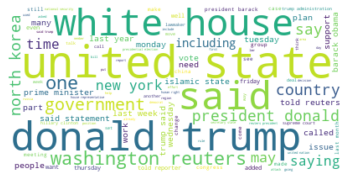

In [28]:
# Create a word cloud of all the true records.
truefilt = df[(df['label_bin'] == 1)]
text = " ".join(article for article in truefilt.clean_text)

# print the number of words across all the articles
print ("There are {} words across all the articles.".format(len(text)))

# Create and generate a word cloud image
wordcloud = WordCloud(max_words=100, background_color="white").generate(text)

# Display the wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

There are 40978019 words across all the articles.


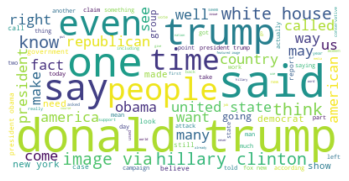

In [29]:
# Create a word cloud of all the fake records.
fakefilt = df[(df['label_bin'] == 0)]
text = " ".join(article for article in fakefilt.clean_text)

# print the number of words across all the articles
print ("There are {} words across all the articles.".format(len(text)))

# Create and generate a word cloud image
wordcloud = WordCloud(max_words=100, background_color="white").generate(text)

# Display the wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Split Train, Test, & Dev Data for Dataset 1

In [90]:
# Split cleaned data set into train (70%), test (15%), & dev (15%).
# Use random_state param to reproduce shuffle outcomes.
train, test = train_test_split(df, random_state=0, train_size=0.7, test_size=0.3, shuffle=True)
num_test = int(len(test)/2)
test = test[num_test:]
dev = test[:num_test]

print("Train data shape:", train.shape)
print("Test data shape:", test.shape)
print("Dev data shape:", dev.shape)

Train data shape: (30979, 12)
Test data shape: (6639, 12)
Dev data shape: (6638, 12)


In [91]:
test.columns

Index(['title', 'text', 'subject', 'date', 'label', 'label_bin', 'titletext',
       'clean_title', 'clean_text', 'clean_titletext', 'word_count',
       'polarity'],
      dtype='object')

In [31]:
# Export train, test, & dev data sets to dir.
# Write a Pandas DataFrame as a zipped CSV file.
# train.to_csv("input/processed-datasets/train.csv", index=False)
# test.to_csv("input/processed-datasets/test.csv", index=False)
# dev.to_csv("input/processed-datasets/dev.csv", index=False)

## Exploratory Data Analysis for Dataset 1

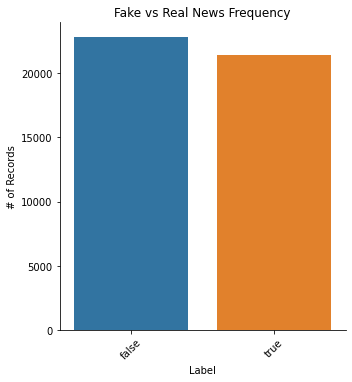

In [32]:
# Histograms looking at the distribution of fake vs real news labels.
g = sns.catplot(data=df, x="label", kind="count")
g.set(xlabel="Label", ylabel="# of Records", title="Fake vs Real News Frequency")
g.set_xticklabels(rotation=45)

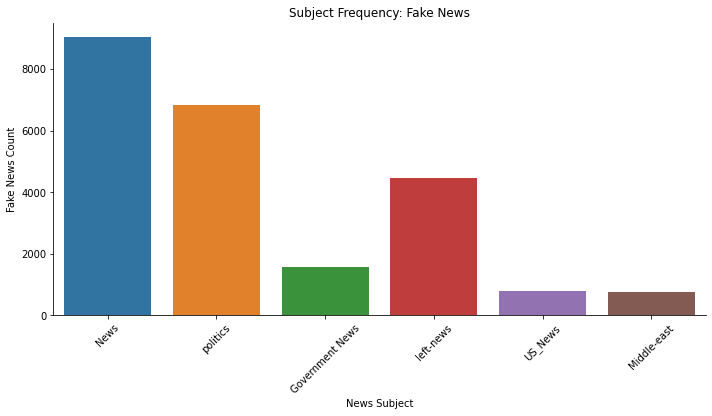

In [33]:
# Histogram looking at the frequency of fake news subjects.
g = sns.catplot(data=fake, x="subject", col="label_bin", kind="count", aspect=2)
g.set(xlabel="News Subject", ylabel="Fake News Count", title="Subject Frequency: Fake News")
g.set_xticklabels(rotation=45)

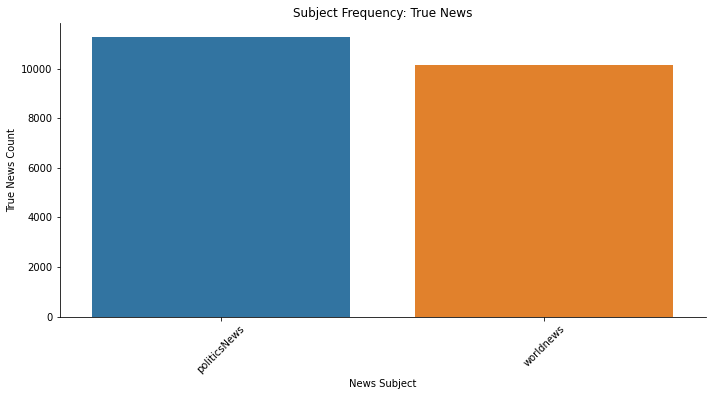

In [34]:
# Histogram looking at the frequency of true news subjects.
g = sns.catplot(data=true, x="subject", col="label_bin", kind="count", aspect=2)
g.set(xlabel="News Subject", ylabel="True News Count", title="Subject Frequency: True News")
g.set_xticklabels(rotation=45)

Though there is no overlap in subjects between fake news and real news, we don't see this as something that will pose a concern since we are not including the subject of the article in the model.

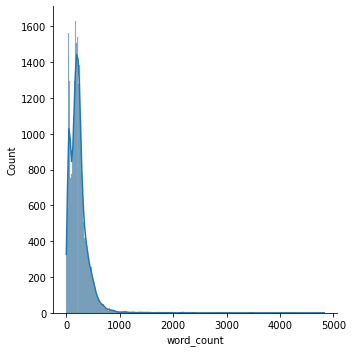

In [35]:
# Distribution of the word count of the clean text values of the news data.
df["word_count"] = df["clean_text"].apply(lambda x: len(str(x).split()))
sns.displot(df["word_count"], kde=True)
fig = plt.gcf()

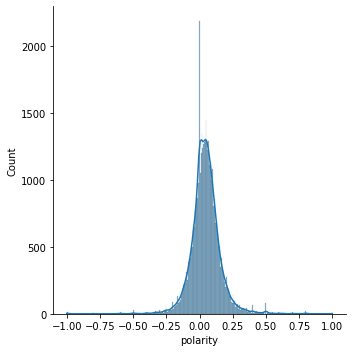

In [36]:
# Distribution of the polarity of the clean text values of the news data. 
# Appears to be neutral on average.
df["polarity"] = df["clean_text"].map(lambda text: TextBlob(text).sentiment.polarity)
sns.displot(df["polarity"], kde=True)
fig = plt.gcf()

Word count in longest real article: 2392
Word count in longest fake article: 4830


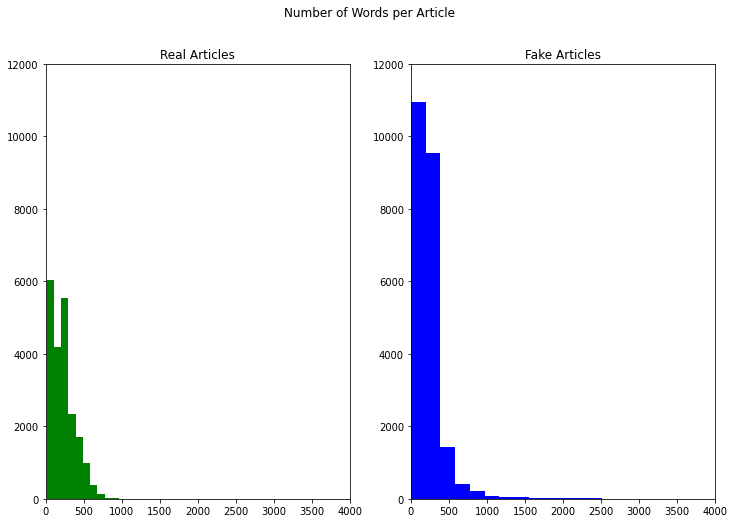

In [37]:
# Histogram of word length in fake news vs. in real news.
fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (12, 8))
ylim = [0, 12000]
ax1.set_ylim(ylim)
ax2.set_ylim(ylim)
xlim = [0, 4000]
ax1.set_xlim(xlim)
ax2.set_xlim(xlim)
text_length = df[df['label_bin'] == 1]['clean_text'].str.split().map(lambda x: len(x))
print("Word count in longest real article:", max(text_length))
ax1.hist(text_length, color='green', bins = 25)
ax1.set_title('Real Articles')
text_length = df[df['label_bin'] == 0]['clean_text'].str.split().map(lambda x: len(x))
print("Word count in longest fake article:", max(text_length))
ax2.hist(text_length, color = 'blue', bins = 25)
ax2.set_title('Fake Articles')
fig.suptitle('Number of Words per Article')
plt.show()

Character count in longest real article: 17958
Character count in longest fake article: 38702


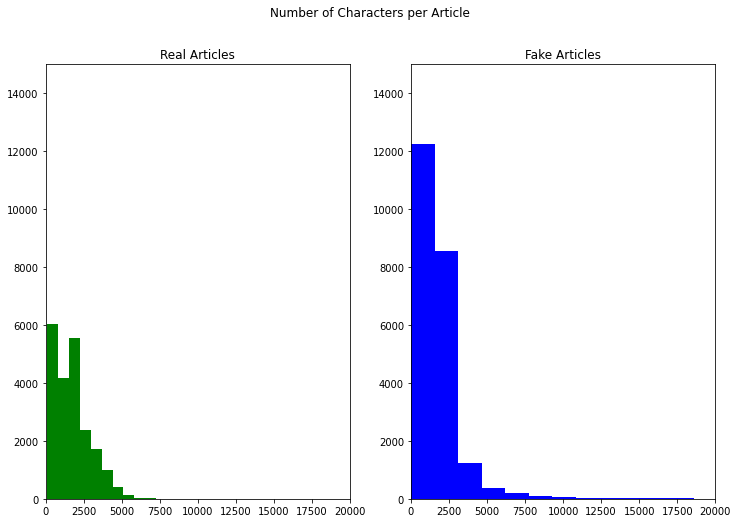

In [38]:
# Histogram of character count in fake news vs. in real news.
fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (12, 8))
ylim = [0, 15000]
ax1.set_ylim(ylim)
ax2.set_ylim(ylim)
xlim = [0, 20000]
ax1.set_xlim(xlim)
ax2.set_xlim(xlim)
text_length = df[df['label_bin'] == 1]['clean_text'].str.len()
print("Character count in longest real article:", max(text_length))
ax1.hist(text_length, color='green', bins = 25)
ax1.set_title('Real Articles')
text_length = df[df['label_bin'] == 0]['clean_text'].str.len()
print("Character count in longest fake article:", max(text_length))
ax2.hist(text_length, color = 'blue', bins = 25)
ax2.set_title('Fake Articles')
fig.suptitle('Number of Characters per Article')
plt.show()

### Word Counts
Get the Top 10 words for real and fake news datasets

In [39]:
df_word_cnt_true = df[df['label']=='true']['clean_text'].str.split(expand=True).stack().value_counts().reset_index()
df_word_cnt_true.columns = ['word', 'freq']
df_word_cnt_true.head(10)

,word,freq
0,said,99010
1,trump,54265
2,would,31507
3,reuters,28402
4,president,26527
5,state,19773
6,government,18305
7,new,16778
8,states,16625
9,house,16552


In [40]:
df_word_cnt_false = df[df['label']=='false']['clean_text'].str.split(expand=True).stack().value_counts().reset_index()
df_word_cnt_false.columns = ['word', 'freq']
df_word_cnt_false.head(10)

,word,freq
0,trump,72947
1,said,30697
2,people,25760
3,president,25291
4,would,23222
5,one,22494
6,clinton,17814
7,obama,17547
8,like,17513
9,donald,16999


# Import Dataset 2

In [41]:
# Read in test dataset. Test dataset does not have labels.
test_zip = zipfile.ZipFile("./input/fake-news-dataset2/test.csv.zip") 
test = pd.read_csv(test_zip.open("test.csv"))
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse Strings, in Silicon Valley - The New York Times",David Streitfeld,"PALO ALTO, Calif. — After years of scorning the political process, Silicon Valley has leapt into the fray. The prospect of a President Donald J. Trump is pushing the tech community to move beyond its traditional role as donors and to embrace a new existence as agitators and activists. A distinguished venture capital firm emblazoned on its corporate home page an earthy epithet. One prominent tech chieftain says the consequences of Mr. Trump’s election would “range between disastrous and ..."
1,20801,Russian warships ready to strike terrorists near Aleppo,NaN,"Russian warships ready to strike terrorists near Aleppo 08.11.2016 | Source: Source: Mil.ru Attack aircraft of the Russian aircraft carrier Admiral Kuznetsov get ready to strike terrorists' positions in the vicinity of Aleppo, sources at the Russian Defense Ministry said, RBC reports. ""Insurgents' attempts to break into Aleppo from outside are meaningless,"" the source said. The main task of the aircraft carrier aviation group is to strike missile and air blows on the terrorists , whose goal ..."
2,20802,"#NoDAPL: Native American Leaders Vow to Stay All Winter, File Lawsuit Against Police",Common Dreams,"Videos #NoDAPL: Native American Leaders Vow to Stay All Winter, File Lawsuit Against Police Amnesty International are sending a delegation of human rights observers to monitor the response of law enforcement to the protests. Be Sociable, Share! (Rob Wilson photo) \nNative American leaders vowed on Saturday to protest through the winter against a North Dakota oil pipeline they say threatens water resources and sacred lands and are planning lawsuits over police treatment of arrested protesters..."
3,20803,"Tim Tebow Will Attempt Another Comeback, This Time in Baseball - The New York Times",Daniel Victor,"If at first you don’t succeed, try a different sport. Tim Tebow, who was a Heisman quarterback at the University of Florida but was unable to hold an N. F. L. job, is pursuing a career in Major League Baseball. He will hold a workout for M. L. B. teams this month, his agents told ESPN and other news outlets. “This may sound like a publicity stunt, but nothing could be further from the truth,” said Brodie Van Wagenen, of CAA Baseball, part of the sports agency CAA Sports, in the statement..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,"42 mins ago 1 Views 0 Comments 0 Likes 'For the first time in history, we’re filming a panoramic video from the station. It means you’ll see everything we see here, with your own eyes. That’s to say, you’ll be able to feel like real cosmonauts' - Borisenko to RT. Video presented by RT in collaboration with the Russian space agency Roscosmos and the rocket and space corporation Energia More on our project website: space360.rt.com Subscribe Like Leave a Reply Login with your Social ID ..."


In [48]:
# Read in Train dataset. Labels: 1: unreliable ; 0: reliable.
train_zip = zipfile.ZipFile("./input/fake-news-dataset2/train.csv.zip") 
df_test2 = pd.read_csv(train_zip.open("train.csv"))
df_test2.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It,Darrell Lucus,"House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well....",1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart",Daniel J. Flynn,"Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress. Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduat...",0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, 2016 \nThe tension between intelligence analysts and political policymakers has always been between honest assessments and desired results, with the latter often overwhelming the former, as in the Iraq War, writes Lawrence Davidson. \nBy Lawrence Davidson \nFor those who might wonder why foreign policy makers repeatedly make bad choices, some insight might be drawn from the following analysis. The action here plays out in the United States, but t...",1
3,3,15 Civilians Killed In Single US Airstrike Have Been Identified,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstrike Have Been Identified The rate at which civilians are being killed by American airstrikes in Afghanistan is now higher than it was in 2014 when the US was engaged in active combat operations. Photo of Hellfire missiles being loaded onto a US military Reaper drone in Afghanistan by Staff Sgt. Brian Ferguson/U.S. Air Force. \nThe Bureau has been able to identify 15 civilians killed in a single US drone strike in Afghanistan last month – the bi...,1
4,4,Iranian woman jailed for fictional unpublished story about woman stoned to death for adultery,Howard Portnoy,"Print \nAn Iranian woman has been sentenced to six years in prison after Iran’s Revolutionary Guard searched her home and found a notebook that contained a fictional story she’d written about a woman who was stoned to death, according to the Eurasia Review . \nGolrokh Ebrahimi Iraee, 35, is the wife of political prisoner Arash Sadeghi, 36, who is serving a 19-year prison sentence for being a human rights activist, the publication reported. \n“When the intelligence unit of the Revolutionary G...",1


In [49]:
# Update labels to match original dataset. 
df_test2['label_bin'] = df_test2['label'].map({1:0 , 0:1})
df_test2['label'] = df_test2['label'].map({1:'false' , 0:'true'})

In [50]:
df_test2.head()

,id,title,author,text,label,label_bin
0,0,House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It,Darrell Lucus,"House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well....",false,0
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart",Daniel J. Flynn,"Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress. Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduat...",true,1
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, 2016 \nThe tension between intelligence analysts and political policymakers has always been between honest assessments and desired results, with the latter often overwhelming the former, as in the Iraq War, writes Lawrence Davidson. \nBy Lawrence Davidson \nFor those who might wonder why foreign policy makers repeatedly make bad choices, some insight might be drawn from the following analysis. The action here plays out in the United States, but t...",false,0
3,3,15 Civilians Killed In Single US Airstrike Have Been Identified,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstrike Have Been Identified The rate at which civilians are being killed by American airstrikes in Afghanistan is now higher than it was in 2014 when the US was engaged in active combat operations. Photo of Hellfire missiles being loaded onto a US military Reaper drone in Afghanistan by Staff Sgt. Brian Ferguson/U.S. Air Force. \nThe Bureau has been able to identify 15 civilians killed in a single US drone strike in Afghanistan last month – the bi...,false,0
4,4,Iranian woman jailed for fictional unpublished story about woman stoned to death for adultery,Howard Portnoy,"Print \nAn Iranian woman has been sentenced to six years in prison after Iran’s Revolutionary Guard searched her home and found a notebook that contained a fictional story she’d written about a woman who was stoned to death, according to the Eurasia Review . \nGolrokh Ebrahimi Iraee, 35, is the wife of political prisoner Arash Sadeghi, 36, who is serving a 19-year prison sentence for being a human rights activist, the publication reported. \n“When the intelligence unit of the Revolutionary G...",false,0


In [51]:
df_test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         20800 non-null  int64 
 1   title      20242 non-null  object
 2   author     18843 non-null  object
 3   text       20761 non-null  object
 4   label      20800 non-null  object
 5   label_bin  20800 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 975.1+ KB


## Clean & Process Dataset 2

In [52]:
# Check for empty records.
df_test2.isna().sum().sum()

2554

In [53]:
# Check columns labeled as the 'object' dtype.
df_test2["title"].apply(type).value_counts()

<class 'str'>      20242
<class 'float'>      558
Name: title, dtype: int64

In [54]:
# Check columns labeled as the 'object' dtype.
df_test2["text"].apply(type).value_counts()

<class 'str'>      20761
<class 'float'>       39
Name: text, dtype: int64

In [59]:
# Inspect float objects in title column.
df_test2_inspect_nulls = df_test2[df_test2["title"].isna()]
df_test2_inspect_nulls.head()

,id,title,author,text,label,label_bin
53,53,NaN,Dairy✓ᵀᴿᵁᴹᴾ,"Sounds like he has our president pegged. What a shame, Obama's ineptness pushed our strategic partner in that area away with the idiotic pushing of PC policies. Duterte has a huge drug problem that is ruining his country and there is only one way to set it back on course. Yes, it's ugly and people get hurt, but cleaning the drugs out is always a hard thing to do and it must be done in order to bring about a civil society again. They should have just left him alone and not tried to tell him h...",false,0
120,120,NaN,Anonymous,"Same people all the time , i dont know how you can fix this corruption http://www.fromthewilderness.com/free/ww3/10_09_01_krongard.html",false,0
124,124,NaN,SeekSearchDestory,"You know, outside of any morality arguments, it seems to me that asking soldiers to give you money after you ask them to get shot at by other people for the privilege of getting shot at in the first place, doesn't seem like a good idea somehow. Is DC vaguely aware what happens to countries that gyp their troops on a regular basis? Or have they watched so much Star Trek in the break room over the years that they've forgotten that problems are not solved peacefully in 60 minutes, or that we ha...",false,0
140,140,NaN,Anonymous,"There is a lot more than meets the eye to this mob , wait till you read this . &quot;Soon thereafter I resigned from Yang and took another job at the Florida Department of Transportation (FDOT). While there, I discovered some other illegal activities of Yang, who had contracts with FDOT, involving over-billing and defrauding of the State of Florida regarding contracts Nee was sentenced on October 7, 2004 by U.S. District Judge Gregory A. Presenell to three years of supervised probation and $...",false,0
196,196,NaN,Raffie,They got the heater turned up on high.,false,0


In [60]:
# Inspect float objects in text column.
df_test2_inspect_nulls = df_test2[df_test2["text"].isna()]
df_test2_inspect_nulls.head()

,id,title,author,text,label,label_bin
142,142,Gorafi Magazine : Entretien exclusif avec Barack Obama « Plus rien à secouer. Démerdez-vous » >> Le Gorafi,NaN,NaN,false,0
573,573,Le top des recherches Google passe en top des recherches Google >> Le Gorafi,NaN,NaN,false,0
1200,1200,La Corée du Nord annonce avoir envoyé un missile balistique de félicitation à Donald Trump >> Le Gorafi,NaN,NaN,false,0
1911,1911,Grand-Prix du Brésil – Romain Grosjean obtient le meilleur temps dans la ligne droite des stands >> Le Gorafi,NaN,NaN,false,0
2148,2148,Gorafi Magazine: Barack Obama « Je vous ai déjà dit que j’en avais plus rien à battre. Lâchez moi maintenant » >> Le Gorafi,NaN,NaN,false,0


In [64]:
# Remove NaN records from the text and title columns.
df_test2_filtered = df_test2.dropna(subset=["title", "text"])

# Confirm count of empty clean text records.
print(f"NaN text records (after removal): {len(df_test2_filtered[df_test2_filtered['text'] == ''])}")
print(f"NaN title records (after removal): {len(df_test2_filtered[df_test2_filtered['title'] == ''])}")
print(f"Filtered df size: {df_test2_filtered.shape}\n")
df_test2_filtered.info()

NaN text records (after removal): 0
NaN title records (after removal): 0
Filtered df size: (20203, 6)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20203 entries, 0 to 20799
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         20203 non-null  int64 
 1   title      20203 non-null  object
 2   author     18285 non-null  object
 3   text       20203 non-null  object
 4   label      20203 non-null  object
 5   label_bin  20203 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.1+ MB


In [68]:
# Combine the title and text columns into one column.
df_test2_filtered['titletext'] = df_test2_filtered['title'] + ' ' + df_test2_filtered['text']

# Clean up text features.
start_time = time.time()
stop_words = set(stopwords.words("english"))

df_test2_filtered["clean_title"] = df_test2_filtered["title"].apply(lambda text: preprocess_text(text))
df_test2_filtered["clean_text"] = df_test2_filtered["text"].apply(lambda text: preprocess_text(text))
df_test2_filtered["clean_titletext"] = df_test2_filtered["titletext"].apply(lambda text: preprocess_text(text))

print(f"{(time.time() - start_time):0.3f} seconds to execute pre-processing text inputs...")

42.721 seconds to execute pre-processing text inputs...


In [69]:
df_test2_filtered['clean_text'] = df_test2_filtered['clean_text'].apply(singlecharacter)

In [70]:
df_test2_filtered.head(2)

,id,title,author,text,label,label_bin,titletext,clean_title,clean_text,clean_titletext
0,0,House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It,Darrell Lucus,"House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well....",false,0,"House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House D...",house dem aide even see comey letter jason chaffetz tweeted,house dem aide even see comey letter jason chaffetz tweeted darrell lucus october 30 2016 subscribe jason chaffetz stump american fork utah image courtesy michael jolley available creative commonslicense apologies keith olbermann doubt worst person world week fbi director james comey according house democratic aide looks like also know secondworst person well turns comey sent infamous letter announcing fbi looking emails may related hillary clinton email server ranking democrats relevant com...,house dem aide even see comey letter jason chaffetz tweeted house dem aide even see comey letter jason chaffetz tweeted darrell lucus october 30 2016 subscribe jason chaffetz stump american fork utah image courtesy michael jolley available creative commonslicense apologies keith olbermann doubt worst person world week fbi director james comey according house democratic aide looks like also know secondworst person well turns comey sent infamous letter announcing fbi looking emails may related...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart",Daniel J. Flynn,"Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress. Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduat...",true,1,"FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress. Speaking of Great Expectations, Hillary Rodham overflowed with them 4...",flynn hillary clinton big woman campus breitbart,ever get feeling life circles roundabout rather heads straight line toward intended destination hillary clinton remains big woman campus leafy liberal wellesley massachusetts everywhere else votes likely inauguration dress remainder days way miss havisham forever wore wedding dress speaking great expectations hillary rodham overflowed 48 years ago first addressed wellesley graduating class president college informed gathered 1969 students needed debate far could ascertain spokesman kind like...,flynn hillary clinton big woman campus breitbart ever get feeling life circles roundabout rather heads st

In [71]:
# Get count of empty clean text records.
print(f"Empty clean text records: {len(df_test2_filtered[df_test2_filtered['clean_text'] == ''])}")
df_test2_filtered[df_test2_filtered["clean_text"] == ""].head()

Empty clean text records: 92


,id,title,author,text,label,label_bin,titletext,clean_title,clean_text,clean_titletext
82,82,Huma’s Weiner Dogs Hillary,Steve Sailer,,false,0,Huma’s Weiner Dogs Hillary,huma weiner dogs hillary,,huma weiner dogs hillary
169,169,Mohamad Khweis: Another “Virginia Man” (Palestinian-American Muslim) Charged With Terrorism,James Fulford,,false,0,Mohamad Khweis: Another “Virginia Man” (Palestinian-American Muslim) Charged With Terrorism,mohamad khweis another virginia man palestinianamerican muslim charged terrorism,,mohamad khweis another virginia man palestinianamerican muslim charged terrorism
295,295,A Connecticut Reader Reports Record Voter Registration–Inspired By Trump,VDARE.com Reader,,false,0,A Connecticut Reader Reports Record Voter Registration–Inspired By Trump,connecticut reader reports record voter registration inspired trump,,connecticut reader reports record voter registration inspired trump
470,470,BULLETIN: There ARE Righteous Jews For Trump!; Rule Or Ruin For GOP Establishment; etc.(60 ITEMS!),admin,,false,0,BULLETIN: There ARE Righteous Jews For Trump!; Rule Or Ruin For GOP Establishment; etc.(60 ITEMS!),bulletin righteous jews trump rule ruin gop establishment etc60 items,,bulletin righteous jews trump rule ruin gop establishment etc60 items
592,592,Is your promising internet career over now Vine is dead? Write for NewsBiscuit to cheer yourself up,newsbiscuit editorial team,,false,0,Is your promising internet career over now Vine is dead? Write for NewsBiscuit to cheer yourself up,promising internet career vine dead write newsbiscuit cheer,,promising internet career vine dead write newsbiscuit cheer


In [75]:
# Remove empty clean text records.
df_test2_filtered = df_test2_filtered[df_test2_filtered["clean_text"] != ""]

# Confirm count of empty clean text records.
print(f"Empty clean text records (after removal): {len(df_test2_filtered[df_test2_filtered['clean_text'] == ''])}")
print(f"Filtered df size: {df_test2_filtered.shape}")
df_test2_filtered[df_test2_filtered["clean_text"] == ""].head()

Empty clean text records (after removal): 0
Filtered df size: (20111, 10)


,id,title,author,text,label,label_bin,titletext,clean_title,clean_text,clean_titletext


In [72]:
# Get count of empty clean title records.
print(f"Empty clean title records: {len(df_test2_filtered[df_test2_filtered['clean_title'] == ''])}")
df_test2_filtered[df_test2_filtered["clean_title"] == ""].head()

Empty clean title records: 152


,id,title,author,text,label,label_bin,titletext,clean_title,clean_text,clean_titletext
47,47,"СМИ Сербии приписали россиянам ""подготовку терактов"" в Черногории",NaN,"0 комментариев 0 поделились Фото: AP \nОднако глава правительства Сербии Александр Вучич отказался комментировать сообщения о высланных россиянах. ""Не все в вашем вопросе неверно, одна часть не точна. Я не хотел вам отвечать не только по той причине, которую уже назвал, но и еще из-за одной вещи — потому, что об этих делах я говорить не имею права по закону"", — сказал Вучич белградскому телеканалу N1. \nНовость о депортации российских граждан совпала с неожиданным приездом в Белград секретар...",false,0,"СМИ Сербии приписали россиянам ""подготовку терактов"" в Черногории 0 комментариев 0 поделились Фото: AP \nОднако глава правительства Сербии Александр Вучич отказался комментировать сообщения о высланных россиянах. ""Не все в вашем вопросе неверно, одна часть не точна. Я не хотел вам отвечать не только по той причине, которую уже назвал, но и еще из-за одной вещи — потому, что об этих делах я говорить не имею права по закону"", — сказал Вучич белградскому телеканалу N1. \nНовость о депортации ро...",,ap n1 26 27 16 16 20 pravdaru viber whatsapp 27 27,0 0 ap n1 26 27 16 16 20 pravdaru viber whatsapp 27 27
229,229,США—КНР: на кого возлагать ответственность за развитие ракетно-ядерной программы КНДР? | Новое восточное обозрение,NaN,"Страна: Китай Заявления КНДР о завершении своей программы развития ядерного оружия вызвали всплеск дискуссий на тему «кто виноват». Точнее, кто несет главную ответственность за то, что ситуация дошла до нынешнего уровня, и на фоне развивающегося противостояния США и КНР Пекин начали обвинять еще и в этом, причем разброс обвинений разнится от «ничего не делал, хотя мог» до «активно помогал». Начнем с высказываний кандидата в президенты США Хиллари Клинтон. 13 октября 2016 г. агентство Associa...",false,0,"США—КНР: на кого возлагать ответственность за развитие ракетно-ядерной программы КНДР? | Новое восточное обозрение Страна: Китай Заявления КНДР о завершении своей программы развития ядерного оружия вызвали всплеск дискуссий на тему «кто виноват». Точнее, кто несет главную ответственность за то, что ситуация дошла до нынешнего уровня, и на фоне развивающегося противостояния США и КНР Пекин начали обвинять еще и в этом, причем разброс обвинений разнится от «ничего не делал, хотя мог» до «актив...",,13 2016 associated press wikileaks 2013 goldman sachs bruce vector 12 2016 14 21 2016 2270 thaad 25 34 2016 18477 27 16,13 2016 associated press wikileaks 2013 goldman sachs bruce vector 1 1 12 2016 14 21 2 2016 2270 4 thaad 25 34 2016 18477 27 6 16 2
371,371,"Путин рассказал, когда в Крыму решат проблему с пресной водой",NaN,"0 комментариев 7 поделились \nОтвечая на соответствующий вопрос участника форума Виктора Тарасова, глава российского государства отметил: ""Мы направили на решение этой задачи из федерального бюджета 23 с лишним миллиарда рублей. С 2015 по 2020 г. планируется в федеральной целевой программе по развитию Крыма и Севастополя еще свыше 40 млрд руб."", — сказал Путин. Он также добавил, что эти деньги необходимо израсходовать рационально. ""Федеральные и региональные органы власти эту проблему должны...",false,0,"Путин рассказал, когда в Крыму решат проблему с пресной водой 0 комментариев 7 поделились \nОтвечая на соответствующий вопрос участника форума Виктора Тарасова, глава российского государства отметил: ""Мы направили на решение этой задачи из федерального бюджета 23 с лишним миллиарда рублей. С 2015 по 2020 г. планируется в федеральной целевой программе по развитию Крыма и Севастополя еще свыше 40 млрд руб."", — сказал Путин. Он также добавил, что эти деньги необходимо израсходовать рационально....",,23 2015 2020 40 45 25 25 pravdaru,0 7 23 2015 2020 40 45 25 25 pravdaru
492,492,Казахстан на страже ядерной безопасности | Новое восточное обозрение,NaN,"В ноябре 2016 г. Мажилис Парламента Республики Казахстан одобрил соз

In [76]:
# Remove empty clean title records.
df_test2_filtered = df_test2_filtered[df_test2_filtered["clean_title"] != ""]

# Confirm count of empty clean title records.
print(f"Empty clean text records (after removal): {len(df_test2_filtered[df_test2_filtered['clean_title'] == ''])}")
print(f"Filtered df size: {df_test2_filtered.shape}")
df_test2_filtered[df_test2_filtered["clean_title"] == ""].head()

Empty clean text records (after removal): 0
Filtered df size: (19973, 10)


,id,title,author,text,label,label_bin,titletext,clean_title,clean_text,clean_titletext


In [77]:
# Get count of special characters in the the title and text columns that look like social posts.
print(f"Number of times clean_text records contain '@' or '#': {df_test2_filtered['clean_text'].str.count('#|@').sum()}")

Number of times clean_text records contain '@' or '#': 0


In [78]:
df_test2_filtered.shape

(19973, 10)

# EDA for Dataset 2

In [79]:
# See the counts of true and fake news articles.
pd.pivot_table(df_test2_filtered, values="id", index="label", aggfunc="count")

,id
label,
false,9587
true,10386


There are 36820805 words across all the true articles.


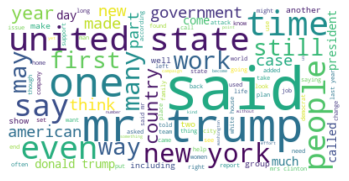

In [80]:
# Create a word cloud of all the true records.
truefilt = df_test2_filtered[(df_test2_filtered['label_bin'] == 1)]
text = " ".join(article for article in truefilt.clean_text)

# Print the number of words across all the articles.
print ("There are {} words across all the true articles.".format(len(text)))

# Create and generate a word cloud image.
wordcloud = WordCloud(max_words=100, background_color="white").generate(text)

# Display the wordcloud.
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

There are 27078155 words across all the fake articles.


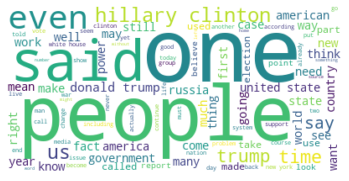

In [81]:
# Create a word cloud of all the fake records.
fakefilt = df_test2_filtered[(df_test2_filtered['label_bin'] == 0)]
text = " ".join(article for article in fakefilt.clean_text)

# Print the number of words across all the articles.
print ("There are {} words across all the fake articles.".format(len(text)))

# Create and generate a word cloud image.
wordcloud = WordCloud(max_words=100, background_color="white").generate(text)

# Display the wordcloud.
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

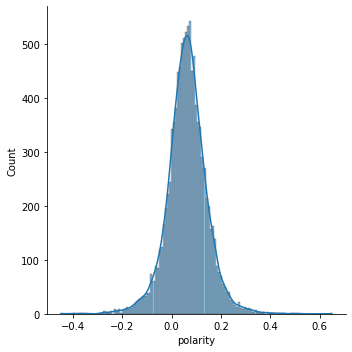

In [82]:
# Distribution of the polarity of the clean text values of the fake news data. 
truefilt["polarity"] = truefilt["clean_text"].map(lambda text: TextBlob(text).sentiment.polarity)
sns.displot(truefilt["polarity"], kde=True)
fig = plt.gcf()

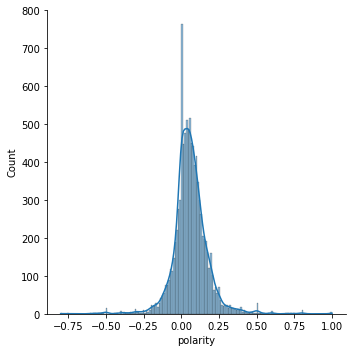

In [83]:
# Distribution of the polarity of the clean text values of the fake news data. 
fakefilt["polarity"] = fakefilt["clean_text"].map(lambda text: TextBlob(text).sentiment.polarity)
sns.displot(fakefilt["polarity"], kde=True)
fig = plt.gcf()

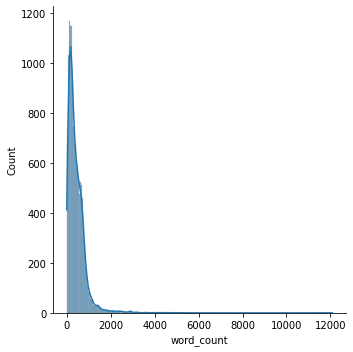

In [84]:
# Distribution of the word count of the clean text values of the news data.
df_test2_filtered["word_count"] = df_test2_filtered["clean_text"].apply(lambda x: len(str(x).split()))
sns.displot(df_test2_filtered["word_count"], kde=True)
fig = plt.gcf()

In [85]:
df_word_cnt_true = df_test2_filtered[df_test2_filtered['label']=='true']['clean_text'].str.split(expand=True).stack().value_counts().reset_index()
df_word_cnt_true.columns = ['word', 'freq']
df_word_cnt_true.head(10)

,word,freq
0,said,68179
1,mr,64571
2,trump,36111
3,would,22803
4,one,22523
5,people,19942
6,new,19660
7,president,16829
8,like,16022
9,also,15526


In [86]:
df_word_cnt_true = df_test2_filtered[df_test2_filtered['label']=='false']['clean_text'].str.split(expand=True).stack().value_counts().reset_index()
df_word_cnt_true.columns = ['word', 'freq']
df_word_cnt_true.head(10)

,word,freq
0,trump,19163
1,clinton,18514
2,people,16256
3,one,15429
4,would,14373
5,us,14047
6,hillary,12421
7,said,11753
8,new,10263
9,like,9993


# Modeling

We began by modeling Dataset 1 using Logistic, Naive Bayes, and K-Nearest Neigbors for Unigram, Bigram, and Trigram feature vector text representations.

In [87]:
train.head(1)
start_1=time.time()

<h2>Modeling with Unigram words</h2>

In [92]:
from sklearn.feature_extraction import text ## Need to re-import because we overwrite text variable in a previous preprocessing function
corpus_train = train['clean_text']
corpus_dev = dev['clean_text']
corpus_test = test['clean_text']
y_train = train['label_bin']
y_dev = dev['label_bin']
y_test = test['label_bin']
additional_words=['reuters','washington']
stop_words = text.ENGLISH_STOP_WORDS.union(additional_words)

cv=CountVectorizer(ngram_range=(1,1),stop_words=stop_words)
X_train=cv.fit_transform(corpus_train)
X_test=cv.transform(corpus_test)

model_lr=LogisticRegression(solver="liblinear", multi_class="auto")
model_lr.fit(X_train,y_train)
y_pred=model_lr.predict(X_test)

<h4> Logistic Model </h4>

In [93]:
f1_score_1=round(metrics.f1_score(y_test,y_pred,average="weighted"),5)
print('Logistic Unigram F1-score:',f1_score_1)

weights=model_lr.coef_ #Get the weights of the logistic regression
sorted_weights=np.argsort(weights)[:,-10:].flatten() 
topic_words=cv.get_feature_names_out()[sorted_weights]  
categories=['true','fake']
topics=categories#set the topics to place in the dataframe
df_topics_lr_1=pd.DataFrame() #create dataframe
df_topics_lr_1['words']=pd.DataFrame(topic_words)
for i in range(1): 
    specific_weight=weights[i][sorted_weights] 
    df_topics_lr_1[topics[i]]=pd.DataFrame(specific_weight,columns=[topics[i]]) 
display(df_topics_lr_1) #showcase the topics and the words for the feature

Logistic Unigram F1-score: 0.98418


,words,true
0,said,1.157679
1,saturday,1.171931
2,representatives,1.237833
3,reporters,1.320686
4,nov,1.343154
5,monday,1.702694
6,friday,1.862934
7,tuesday,2.022148
8,thursday,2.075679
9,wednesday,2.186411


<h4> Naive Bayes Model </h4>

In [94]:
df_alpha_stats_1=pd.DataFrame() #Create dataframe to hold alpha stats
alpha=[.001,.01,.1,1,2,5,10] #alpha-values for testing for Naive-Bayes model
for i in alpha:
    nb_stats={'Model':'Naive-Bayes','Alpha':None,'F1-Score':None} 
    nb_stats['Alpha']=i 
    nb_model=MultinomialNB(alpha=i) 
    nb_model.fit(X_train,y_train) 
    nb_pred=nb_model.predict(X_test) #Predict on dev dataset
    nb_model_f1=metrics.f1_score(y_test,nb_pred,average="weighted") #Get f1-score based on the dev labels and predicted values
    nb_stats['F1-Score']=round(nb_model_f1,4) #Make it pretty
    df_alpha_stats_1=df_alpha_stats_1.append(nb_stats,ignore_index=True)  #place the values in dataframe
print('\nShow Alpha and F1-Score for Naive-Bayes Model','\n',df_alpha_stats_1.to_string(index=False,justify='center'))

weights=nb_model.coef_ #Get the weights of the logistic regression
sorted_weights=np.argsort(weights)[:,-10:].flatten() #sort them in order to get the top 5 weights per topic
topic_words=cv.get_feature_names_out()[sorted_weights]
categories=['true','fake']
topics=categories#set the topics to place in the dataframe
df_topics_nb_1=pd.DataFrame() #create dataframe
df_topics_nb_1['words']=pd.DataFrame(topic_words) #create the column of words for the top 20 words in each category
for i in range(1): #create for loop to go through the topics
    specific_weight=weights[i][sorted_weights] #Get the specific weight for that word
    df_topics_nb_1[topics[i]]=pd.DataFrame(specific_weight,columns=[topics[i]]) #Place the word and topics in the row
display(df_topics_nb_1) #showcase the topics and the words for the feature


Show Alpha and F1-Score for Naive-Bayes Model 
    Model     Alpha  F1-Score
Naive-Bayes  0.001   0.9560 
Naive-Bayes  0.010   0.9548 
Naive-Bayes  0.100   0.9506 
Naive-Bayes  1.000   0.9404 
Naive-Bayes  2.000   0.9372 
Naive-Bayes  5.000   0.9348 
Naive-Bayes 10.000   0.9348 


,words,true
0,republican,-6.160225
1,united,-6.136995
2,house,-6.093670
3,states,-6.080096
4,new,-6.075268
5,government,-5.976500
6,state,-5.906687
7,president,-5.607051
8,trump,-4.899787
9,said,-4.288408


<h4> KNN Model </h4>

In [95]:
knn_values=[1,3,5,7,9]
df_k_stats_1=pd.DataFrame()
knn_stats={'Model':'KNN','K-value':None,'F1-Score':None} #Create dictionary to hold KNN stats to append with dataframe
for i in knn_values:
    knn_stats['K-value'] = i 
    knn_model = KNeighborsClassifier(n_neighbors = i) 
    knn_model.fit(X_train,y_train) 
    knn_pred=knn_model.predict(X_test) #Predict on dev dataset 
    knn_model_f1=metrics.f1_score(y_test,knn_pred,average="weighted") #Get f1-score based on the dev labels and predicted values
    knn_stats['F1-Score'] = round(knn_model_f1,4) #Make it pretty
    df_k_stats_1 = df_k_stats_1.append(knn_stats, ignore_index=True) #place the values in dataframe
print('Show K1 and F1-Score for KNN Model','\n',df_k_stats_1.to_string(index=False,justify='center'))

Show K1 and F1-Score for KNN Model 
 Model  K-value  F1-Score
 KNN    1.0      0.8025 
 KNN    3.0      0.7668 
 KNN    5.0      0.7477 
 KNN    7.0      0.7435 
 KNN    9.0      0.7356 


<h2>Modeling with Bigram words</h2>

In [96]:
corpus_train = train['clean_text']
corpus_dev = dev['clean_text']
corpus_test = test['clean_text']
y_train = train['label_bin']
y_dev = dev['label_bin']
y_test = test['label_bin']
additional_words=['reuters','washington']
stop_words = text.ENGLISH_STOP_WORDS.union(additional_words)

cv_2=CountVectorizer(ngram_range=(2,2),stop_words=stop_words)
X_train=cv_2.fit_transform(corpus_train)
X_test=cv_2.transform(corpus_test)

<h4> Logistic Model </h4>

In [97]:
model_lr_2=LogisticRegression(solver="liblinear", multi_class="auto")
model_lr_2.fit(X_train,y_train)
y_pred=model_lr_2.predict(X_test)
f1_score_2=round(metrics.f1_score(y_test,y_pred,average="weighted"),5)
print('Logistic Bigram F1-Score',f1_score_2)

Logistic Bigram F1-Score 0.97122


<h4> Naive Bayes Model </h4>

In [98]:
df_alpha_stats_2=pd.DataFrame() #Create dataframe to hold alpha stats
alpha=[.001,.01,.1,1,2,5,10] #alpha-values for testing for Naive-Bayes model
for i in alpha:
    nb_stats={'Model':'Naive-Bayes','Alpha':None,'F1-Score':None} 
    nb_stats['Alpha']=i 
    nb_model=MultinomialNB(alpha=i) 
    nb_model.fit(X_train,y_train) 
    nb_pred=nb_model.predict(X_test) #Predict on dev dataset
    nb_model_f1=metrics.f1_score(y_test,nb_pred,average="weighted") #Get f1-score based on the dev labels and predicted values
    nb_stats['F1-Score']=round(nb_model_f1,4) #Make it pretty
    df_alpha_stats_2=df_alpha_stats_2.append(nb_stats,ignore_index=True)  #place the values in dataframe
print('\nShow Alpha and F1-Score for Naive-Bayes Model','\n',df_alpha_stats_2.to_string(index=False,justify='center'))

weights=nb_model.coef_ #Get the weights of the logistic regression
sorted_weights=np.argsort(weights)[:,-10:].flatten() #sort them in order to get the top 5 weights per topic
topic_words=cv_2.get_feature_names_out()[sorted_weights] #Grab the words from the top 5 weights 
categories=['true','fake']
topics=categories#set the topics to place in the dataframe
df_topics_nb_2=pd.DataFrame() #create dataframe
df_topics_nb_2['words']=pd.DataFrame(topic_words) #create the column of words for the top 20 words in each category
for i in range(1): #create for loop to go through the topics
    print(i)
    specific_weight=weights[i][sorted_weights] #Get the specific weight for that word
    df_topics_nb_2[topics[i]]=pd.DataFrame(specific_weight,columns=[topics[i]]) #Place the word and topics in the row
display(df_topics_nb_2) #showcase the topics and the words for the feature


Show Alpha and F1-Score for Naive-Bayes Model 
    Model     Alpha  F1-Score
Naive-Bayes  0.001   0.9649 
Naive-Bayes  0.010   0.9664 
Naive-Bayes  0.100   0.9688 
Naive-Bayes  1.000   0.9720 
Naive-Bayes  2.000   0.9703 
Naive-Bayes  5.000   0.9685 
Naive-Bayes 10.000   0.9661 
0


,words,true
0,islamic state,-9.527698
1,trump said,-9.501354
2,said statement,-9.405680
3,prime minister,-9.357080
4,new york,-9.281736
5,north korea,-9.057437
6,president donald,-9.013265
7,white house,-8.648131
8,donald trump,-8.462208
9,united states,-8.272298


<h4> KNN Model </h4>

In [99]:
knn_values=[1,3,5,7,9]
df_k_stats_2=pd.DataFrame()
knn_stats={'Model':'KNN','K-value':None,'F1-Score':None} #Create dictionary to hold KNN stats to append with dataframe
for i in knn_values:
    knn_stats['K-value'] = i 
    knn_model = KNeighborsClassifier(n_neighbors = i) 
    knn_model.fit(X_train,y_train) 
    knn_pred=knn_model.predict(X_test) #Predict on dev dataset 
    knn_model_f1=metrics.f1_score(y_test,knn_pred,average="weighted") #Get f1-score based on the dev labels and predicted values
    knn_stats['F1-Score'] = round(knn_model_f1,5) #Make it pretty
    df_k_stats_2 = df_k_stats_2.append(knn_stats, ignore_index=True) #place the values in dataframe
print('Show K1 and F1-Score for KNN Model','\n',df_k_stats_2.to_string(index=False,justify='center'))

Show K1 and F1-Score for KNN Model 
 Model  K-value  F1-Score
 KNN    1.0     0.50637 
 KNN    3.0     0.42563 
 KNN    5.0     0.40525 
 KNN    7.0     0.39125 
 KNN    9.0     0.38755 


<h2> Modeling with Trigram words </h2>

In [100]:
corpus_train = train['clean_text']
corpus_dev = dev['clean_text']
corpus_test = test['clean_text']
y_train = train['label_bin']
y_dev = dev['label_bin']
y_test = test['label_bin']
additional_words=['reuters','washington']
stop_words = text.ENGLISH_STOP_WORDS.union(additional_words)
cv_3=CountVectorizer(ngram_range=(3,3),stop_words=stop_words)
X_train=cv_3.fit_transform(corpus_train)
X_test=cv_3.transform(corpus_test)

<h4> Logistic Model </h4>

In [101]:
model_lr_3=LogisticRegression(solver="liblinear", multi_class="auto")
model_lr_3.fit(X_train,y_train)
y_pred=model_lr_3.predict(X_test)
f1_score_3=round(metrics.f1_score(y_test,y_pred,average="weighted"),5)
print('Logistic Trigram Word F1-Score',f1_score_3)

Logistic Trigram Word F1-Score 0.91292


<h4> Naive-Bayes Model </h4>

In [102]:
df_alpha_stats_3=pd.DataFrame() #Create dataframe to hold alpha stats
alpha=[.001,.01,.1,1,2,5,10] #alpha-values for testing for Naive-Bayes model
for i in alpha:
    nb_stats={'Model':'Naive-Bayes','Alpha':None,'F1-Score':None} 
    nb_stats['Alpha']=i 
    nb_model=MultinomialNB(alpha=i) 
    nb_model.fit(X_train,y_train) 
    nb_pred=nb_model.predict(X_test) #Predict on dev dataset
    nb_model_f1=metrics.f1_score(y_test,nb_pred,average="weighted") #Get f1-score based on the dev labels and predicted values
    nb_stats['F1-Score']=round(nb_model_f1,4) #Make it pretty
    df_alpha_stats_3=df_alpha_stats_3.append(nb_stats,ignore_index=True)  #place the values in dataframe
print('\nShow Alpha and F1-Score for Naive-Bayes Model','\n',df_alpha_stats_3.to_string(index=False,justify='center'))

weights=nb_model.coef_ 
sorted_weights=np.argsort(weights)[:,-10:].flatten() 
topic_words=cv_3.get_feature_names_out()[sorted_weights] 
categories=['true','fake']
topics=categories#set the topics to place in the dataframe
df_topics_nb_3=pd.DataFrame() #create dataframe
df_topics_nb_3['words']=pd.DataFrame(topic_words) #create the column of words for the top 20 words in each category
for i in range(1): #create for loop to go through the topics
    print(i)
    specific_weight=weights[i][sorted_weights] #Get the specific weight for that word
    df_topics_nb_3[topics[i]]=pd.DataFrame(specific_weight,columns=[topics[i]]) #Place the word and topics in the row
display(df_topics_nb_3) 


Show Alpha and F1-Score for Naive-Bayes Model 
    Model     Alpha  F1-Score
Naive-Bayes  0.001   0.9554 
Naive-Bayes  0.010   0.9571 
Naive-Bayes  0.100   0.9586 
Naive-Bayes  1.000   0.9586 
Naive-Bayes  2.000   0.9590 
Naive-Bayes  5.000   0.9558 
Naive-Bayes 10.000   0.9528 
0


,words,true
0,national security adviser,-11.722006
1,speaker paul ryan,-11.705670
2,russian president vladimir,-11.703358
3,secretary state rex,-11.598228
4,state rex tillerson,-11.594079
5,president vladimir putin,-11.446158
6,presidentelect donald trump,-11.368867
7,white house said,-11.215897
8,president barack obama,-10.132531
9,president donald trump,-9.471086


<h4> KNN Model </h4>

In [103]:
knn_values=[1,3,5,7,9]
df_k_stats_3=pd.DataFrame()
knn_stats={'Model':'KNN','K-value':None,'F1-Score':None} #Create dictionary to hold KNN stats to append with dataframe
for i in knn_values:
    knn_stats['K-value'] = i 
    knn_model = KNeighborsClassifier(n_neighbors = i) 
    knn_model.fit(X_train,y_train) 
    knn_pred=knn_model.predict(X_test) #Predict on dev dataset 
    knn_model_f1=metrics.f1_score(y_test,knn_pred,average="weighted") #Get f1-score based on the dev labels and predicted values
    knn_stats['F1-Score'] = round(knn_model_f1,4) #Make it pretty
    df_k_stats_3 = df_k_stats_3.append(knn_stats, ignore_index=True) #place the values in dataframe
print('Show K1 and F1-Score for KNN Model','\n',df_k_stats_3.to_string(index=False,justify='center'))

Show K1 and F1-Score for KNN Model 
 Model  K-value  F1-Score
 KNN    1.0      0.4091 
 KNN    3.0      0.3593 
 KNN    5.0      0.3524 
 KNN    7.0      0.3487 
 KNN    9.0      0.3481 


<h1> Model Analysis based on Max Features </h1>

In [104]:
corpus_train = train['clean_text']
corpus_dev = dev['clean_text']
corpus_test = test['clean_text']
y_train = train['label_bin']
y_dev = dev['label_bin']
y_test = test['label_bin']
additional_words=['reuters','washington']
stop_words = text.ENGLISH_STOP_WORDS.union(additional_words)

max_features=[10,100,1000,10000,100000]
df_lr_performance=pd.DataFrame()
lr_perf={'Model':'Logistic Regression','Features Count':None,'F1-Score':None,'Performance Time':None}
for i in max_features:
    lr_perf['Features Count']=i
    start = time.time()
    cv=CountVectorizer(ngram_range=(1,1),stop_words=stop_words,max_features=i)
    X_train=cv.fit_transform(corpus_train)
    X_test=cv.transform(corpus_test)
    model_lr=LogisticRegression(solver="liblinear", multi_class="auto")
    model_lr.fit(X_train,y_train)
    y_pred=model_lr.predict(X_test)
    duration=time.time()-start
    f1_score=round(metrics.f1_score(y_test,y_pred,average="weighted"),5)
    lr_perf['F1-Score']=f1_score
    lr_perf['Performance Time']=duration
    df_lr_performance = df_lr_performance.append(lr_perf, ignore_index=True)
    print(i,duration,f1_score)

#Adding the final performance after 100K features have been added
lr_perf={'Model':'Logistic Regression','Features Count':None,'F1-Score':None,'Performance Time':None}
start = time.time()
cv=CountVectorizer(ngram_range=(1,1),stop_words=stop_words)
X_train=cv.fit_transform(corpus_train)
X_test=cv.transform(corpus_test)
model_lr=LogisticRegression(solver="liblinear", multi_class="auto")
model_lr.fit(X_train,y_train)
y_pred=model_lr.predict(X_test)
duration=time.time()-start
f1_score=round(metrics.f1_score(y_test,y_pred,average="weighted"),5)
lr_perf['F1-Score']=f1_score
lr_perf['Performance Time']=duration
lr_perf['Features Count']=len(cv.get_feature_names_out())
df_lr_performance = df_lr_performance.append(lr_perf, ignore_index=True)
df_lr_performance['Features Count']=df_lr_performance['Features Count'].astype(int)



10 5.185238838195801 0.77309
100 5.2990148067474365 0.91369
1000 7.230772972106934 0.96641
10000 8.302148818969727 0.98208
100000 9.469773054122925 0.98403


,Model,Features Count,F1-Score,Performance Time
0,Logistic Regression,10,0.77309,5.185239
1,Logistic Regression,100,0.91369,5.299015
2,Logistic Regression,1000,0.96641,7.230773
3,Logistic Regression,10000,0.98208,8.302149
4,Logistic Regression,100000,0.98403,9.469773
5,Logistic Regression,192684,0.98418,9.754984


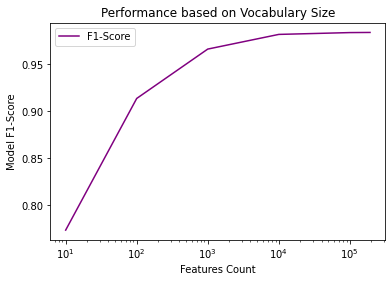

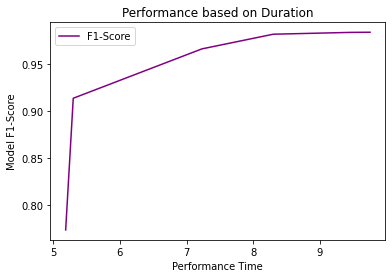

In [105]:
#Graphing and Display Performance with Feature Size

df_lr_performance.plot.line(x='Features Count',y='F1-Score',ylabel='Model F1-Score',title='Performance based on Vocabulary Size',logx=True,color='purple') #Create plot with purple because purple is cool.  
df_lr_performance.plot.line(x='Performance Time',y='F1-Score',ylabel='Model F1-Score',title='Performance based on Duration',logx=False,color='purple') #Create plot with purple because purple is cool.  
display(df_lr_performance)

<h2>F1 Score Analysis with all Models </h2>

In [106]:
df_all_models=pd.DataFrame()
logistic_models={'Model':None,'Special Characteristic':None,'F1-Score':None}
log_models={'Logistic Model Unigram':f1_score_1,'Logistic Model Bigram':f1_score_2,'Logistic Model Trigram':f1_score_3}
knn_models=[df_k_stats_1,df_k_stats_2,df_k_stats_3]
for i in log_models:
    logistic_models['Model']=i
    logistic_models['F1-Score']=log_models[i]
    df_all_models=df_all_models.append(logistic_models, ignore_index=True)
nb_models=[df_alpha_stats_1,df_alpha_stats_2,df_alpha_stats_3]
count=0
for i in nb_models:
    max_value_1=i.loc[i['F1-Score'].idxmax()]
    if count==0:
        max_value_1=max_value_1.replace(to_replace='Naive-Bayes',value='Naive-Bayes Unigram')
        count+=1
        df_all_models=df_all_models.append(max_value_1,ignore_index=True)
        continue
    if count==1:
        max_value_1=max_value_1.replace(to_replace='Naive-Bayes',value='Naive-Bayes Bigram')
        count+=1
        df_all_models=df_all_models.append(max_value_1,ignore_index=True)

        continue
    if count==2:
        max_value_1=max_value_1.replace(to_replace='Naive-Bayes',value='Naive-Bayes Trigram')
        df_all_models=df_all_models.append(max_value_1,ignore_index=True)
        continue
count=0
for i in knn_models:
    max_value_1=i.loc[i['F1-Score'].idxmax()]
    if count==0:
        max_value_1=max_value_1.replace(to_replace='KNN',value='KNN Unigram')
        count+=1
        df_all_models=df_all_models.append(max_value_1,ignore_index=True)
        continue
    if count==1:
        max_value_1=max_value_1.replace(to_replace='KNN',value='KNN Bigram')
        count+=1
        df_all_models=df_all_models.append(max_value_1,ignore_index=True)

        continue
    if count==2:
        max_value_1=max_value_1.replace(to_replace='KNN',value='KNN Trigram')
        df_all_models=df_all_models.append(max_value_1,ignore_index=True)
        continue

df_all_models['Special Characteristic']=df_all_models['Special Characteristic'].combine_first(df_all_models['Alpha'])
df_all_models['Special Characteristic']=df_all_models['Special Characteristic'].combine_first(df_all_models['K-value'])
df_all_models=df_all_models.drop(columns=['Alpha', 'K-value'])
display(df_all_models)


,Model,Special Characteristic,F1-Score
0,Logistic Model Unigram,NaN,0.98418
1,Logistic Model Bigram,NaN,0.97122
2,Logistic Model Trigram,NaN,0.91292
3,Naive-Bayes Unigram,0.001,0.95600
4,Naive-Bayes Bigram,1.0,0.97200
5,Naive-Bayes Trigram,2.0,0.95900
6,KNN Unigram,1.0,0.80250
7,KNN Bigram,1.0,0.50637
8,KNN Trigram,1.0,0.40910


<AxesSubplot:title={'center':'F1-Score All Models'}, xlabel='Model'>

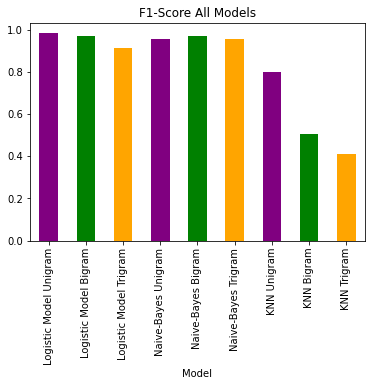

In [107]:
# Plot F1 score of all models.
df_all_models.plot.bar(x='Model',y='F1-Score',color=['purple','green','orange'],title='F1-Score All Models',legend=False)


In [108]:
# Print time it takes to run all models.
end_1=time.time()
duration=((start_1-end_1)*-1)/60
print(f'The total time it takes for all of modeling to finish is {duration} minutes')

The total time it takes for all of modeling to finish is 9.803922533988953 minutes


# Evaluate Models based on Dataset 2

In [109]:
## Need to re-import because we overwrite text variable in a previous preprocessing function
from sklearn.feature_extraction import text

corpus_train = train['clean_text']
corpus_test = df_test2_filtered['clean_text']
y_train = train['label_bin']
y_test = df_test2_filtered['label_bin']

additional_words=['reuters','washington']
stop_words = text.ENGLISH_STOP_WORDS.union(additional_words)

cv=CountVectorizer(ngram_range=(1,1),stop_words=stop_words)
X_train=cv.fit_transform(corpus_train)
X_test=cv.transform(corpus_test)

model_lr=LogisticRegression(solver="liblinear", multi_class="auto")
model_lr.fit(X_train,y_train)
y_pred=model_lr.predict(X_test)

In [110]:
f1_score_1=round(metrics.f1_score(y_test,y_pred,average="weighted"),5)
print('Logistic Unigram F1-score:',f1_score_1)

Logistic Unigram F1-score: 0.52416


In [111]:
df_alpha_stats_1=pd.DataFrame() #Create dataframe to hold alpha stats
alpha=[.001,.01,.1,1,2,5,10] #alpha-values for testing for Naive-Bayes model
for i in alpha:
    nb_stats={'Model':'Naive-Bayes','Alpha':None,'F1-Score':None} 
    nb_stats['Alpha']=i 
    nb_model=MultinomialNB(alpha=i) 
    nb_model.fit(X_train,y_train) 
    nb_pred=nb_model.predict(X_test) #Predict on dev dataset
    nb_model_f1=metrics.f1_score(y_test,nb_pred,average="weighted") #Get f1-score based on the dev labels and predicted values
    nb_stats['F1-Score']=round(nb_model_f1,4) #Make it pretty
    df_alpha_stats_1=df_alpha_stats_1.append(nb_stats,ignore_index=True)  #place the values in dataframe
print('\nShow Alpha and F1-Score for Naive-Bayes Model','\n',df_alpha_stats_1.to_string(index=False,justify='center'))


Show Alpha and F1-Score for Naive-Bayes Model 
    Model     Alpha  F1-Score
Naive-Bayes  0.001   0.5350 
Naive-Bayes  0.010   0.5354 
Naive-Bayes  0.100   0.5357 
Naive-Bayes  1.000   0.5387 
Naive-Bayes  2.000   0.5377 
Naive-Bayes  5.000   0.5331 
Naive-Bayes 10.000   0.5285 


In [112]:
knn_values=[1,3,5,7,9]
df_k_stats_1=pd.DataFrame()
knn_stats={'Model':'KNN','K-value':None,'F1-Score':None} #Create dictionary to hold KNN stats to append with dataframe
for i in knn_values:
    knn_stats['K-value'] = i 
    knn_model = KNeighborsClassifier(n_neighbors = i) 
    knn_model.fit(X_train,y_train) 
    knn_pred=knn_model.predict(X_test) #Predict on dev dataset 
    knn_model_f1=metrics.f1_score(y_test,knn_pred,average="weighted") #Get f1-score based on the dev labels and predicted values
    knn_stats['F1-Score'] = round(knn_model_f1,4) #Make it pretty
    df_k_stats_1 = df_k_stats_1.append(knn_stats, ignore_index=True) #place the values in dataframe
print('Show K1 and F1-Score for KNN Model','\n',df_k_stats_1.to_string(index=False,justify='center'))

Show K1 and F1-Score for KNN Model 
 Model  K-value  F1-Score
 KNN    1.0      0.6209 
 KNN    3.0      0.6230 
 KNN    5.0      0.6361 
 KNN    7.0      0.6361 
 KNN    9.0      0.6398 


### Evaluation Bi-grams

In [113]:
corpus_train = train['clean_text']
corpus_test = df_test2_filtered['clean_text']
y_train = train['label_bin']
y_test = df_test2_filtered['label_bin']
additional_words=['reuters','washington']
stop_words = text.ENGLISH_STOP_WORDS.union(additional_words)

cv_2=CountVectorizer(ngram_range=(2,2),stop_words=stop_words)
X_train=cv_2.fit_transform(corpus_train)
X_test=cv_2.transform(corpus_test)

In [114]:
model_lr_2=LogisticRegression(solver="liblinear", multi_class="auto")
model_lr_2.fit(X_train,y_train)
y_pred=model_lr_2.predict(X_test)
f1_score_2=round(metrics.f1_score(y_test,y_pred,average="weighted"),5)
print('Logistic Bigram F1-Score',f1_score_2)

Logistic Bigram F1-Score 0.56845


In [115]:
df_alpha_stats_2=pd.DataFrame() #Create dataframe to hold alpha stats
alpha=[.001,.01,.1,1,2,5,10] #alpha-values for testing for Naive-Bayes model
for i in alpha:
    nb_stats={'Model':'Naive-Bayes','Alpha':None,'F1-Score':None} 
    nb_stats['Alpha']=i 
    nb_model=MultinomialNB(alpha=i) 
    nb_model.fit(X_train,y_train) 
    nb_pred=nb_model.predict(X_test) #Predict on dev dataset
    nb_model_f1=metrics.f1_score(y_test,nb_pred,average="weighted") #Get f1-score based on the dev labels and predicted values
    nb_stats['F1-Score']=round(nb_model_f1,4) #Make it pretty
    df_alpha_stats_2=df_alpha_stats_2.append(nb_stats,ignore_index=True)  #place the values in dataframe
print('\nShow Alpha and F1-Score for Naive-Bayes Model','\n',df_alpha_stats_2.to_string(index=False,justify='center'))


Show Alpha and F1-Score for Naive-Bayes Model 
    Model     Alpha  F1-Score
Naive-Bayes  0.001   0.5728 
Naive-Bayes  0.010   0.5753 
Naive-Bayes  0.100   0.5806 
Naive-Bayes  1.000   0.5820 
Naive-Bayes  2.000   0.5806 
Naive-Bayes  5.000   0.5822 
Naive-Bayes 10.000   0.5837 


In [116]:
knn_values=[1,3,5,7,9]
df_k_stats_2=pd.DataFrame()
knn_stats={'Model':'KNN','K-value':None,'F1-Score':None} #Create dictionary to hold KNN stats to append with dataframe
for i in knn_values:
    knn_stats['K-value'] = i 
    knn_model = KNeighborsClassifier(n_neighbors = i) 
    knn_model.fit(X_train,y_train) 
    knn_pred=knn_model.predict(X_test) #Predict on dev dataset 
    knn_model_f1=metrics.f1_score(y_test,knn_pred,average="weighted") #Get f1-score based on the dev labels and predicted values
    knn_stats['F1-Score'] = round(knn_model_f1,5) #Make it pretty
    df_k_stats_2 = df_k_stats_2.append(knn_stats, ignore_index=True) #place the values in dataframe
print('Show K1 and F1-Score for KNN Model','\n',df_k_stats_2.to_string(index=False,justify='center'))

Show K1 and F1-Score for KNN Model 
 Model  K-value  F1-Score
 KNN    1.0     0.38926 
 KNN    3.0     0.37464 
 KNN    5.0     0.36777 
 KNN    7.0     0.36312 
 KNN    9.0     0.36013 


### Tri-grams

In [117]:
corpus_train = train['clean_text']
corpus_test = df_test2_filtered['clean_text']
y_train = train['label_bin']
y_test = df_test2_filtered['label_bin']

additional_words=['reuters','washington']
stop_words = text.ENGLISH_STOP_WORDS.union(additional_words)
cv_3=CountVectorizer(ngram_range=(3,3),stop_words=stop_words)
X_train=cv_3.fit_transform(corpus_train)
X_test=cv_3.transform(corpus_test)

In [118]:
model_lr_3=LogisticRegression(solver="liblinear", multi_class="auto")
model_lr_3.fit(X_train,y_train)
y_pred=model_lr_3.predict(X_test)
f1_score_3=round(metrics.f1_score(y_test,y_pred,average="weighted"),5)
print('Logistic Trigram Word F1-Score',f1_score_3)

Logistic Trigram Word F1-Score 0.53931


In [119]:
df_alpha_stats_3=pd.DataFrame() #Create dataframe to hold alpha stats
alpha=[.001,.01,.1,1,2,5,10] #alpha-values for testing for Naive-Bayes model
for i in alpha:
    nb_stats={'Model':'Naive-Bayes','Alpha':None,'F1-Score':None} 
    nb_stats['Alpha']=i 
    nb_model=MultinomialNB(alpha=i) 
    nb_model.fit(X_train,y_train) 
    nb_pred=nb_model.predict(X_test) #Predict on dev dataset
    nb_model_f1=metrics.f1_score(y_test,nb_pred,average="weighted") #Get f1-score based on the dev labels and predicted values
    nb_stats['F1-Score']=round(nb_model_f1,4) #Make it pretty
    df_alpha_stats_3=df_alpha_stats_3.append(nb_stats,ignore_index=True)  #place the values in dataframe
print('\nShow Alpha and F1-Score for Naive-Bayes Model','\n',df_alpha_stats_3.to_string(index=False,justify='center'))


Show Alpha and F1-Score for Naive-Bayes Model 
    Model     Alpha  F1-Score
Naive-Bayes  0.001   0.6027 
Naive-Bayes  0.010   0.6055 
Naive-Bayes  0.100   0.6072 
Naive-Bayes  1.000   0.6100 
Naive-Bayes  2.000   0.6136 
Naive-Bayes  5.000   0.6189 
Naive-Bayes 10.000   0.6229 


In [120]:
knn_values=[1,3,5,7,9]
df_k_stats_3=pd.DataFrame()
knn_stats={'Model':'KNN','K-value':None,'F1-Score':None} #Create dictionary to hold KNN stats to append with dataframe
for i in knn_values:
    knn_stats['K-value'] = i 
    knn_model = KNeighborsClassifier(n_neighbors = i) 
    knn_model.fit(X_train,y_train) 
    knn_pred=knn_model.predict(X_test) #Predict on dev dataset 
    knn_model_f1=metrics.f1_score(y_test,knn_pred,average="weighted") #Get f1-score based on the dev labels and predicted values
    knn_stats['F1-Score'] = round(knn_model_f1,4) #Make it pretty
    df_k_stats_3 = df_k_stats_3.append(knn_stats, ignore_index=True) #place the values in dataframe
print('Show K1 and F1-Score for KNN Model','\n',df_k_stats_3.to_string(index=False,justify='center'))

Show K1 and F1-Score for KNN Model 
 Model  K-value  F1-Score
 KNN    1.0      0.3126 
 KNN    3.0      0.3118 
 KNN    5.0      0.3118 
 KNN    7.0      0.3116 
 KNN    9.0      0.3115 


In [121]:
df_all_models=pd.DataFrame()
logistic_models={'Model':None,'Special Characteristic':None,'F1-Score':None}
log_models={'Logistic Model Unigram':f1_score_1,'Logistic Model Bigram':f1_score_2,'Logistic Model Trigram':f1_score_3}
knn_models=[df_k_stats_1,df_k_stats_2,df_k_stats_3]
for i in log_models:
    logistic_models['Model']=i
    logistic_models['F1-Score']=log_models[i]
    df_all_models=df_all_models.append(logistic_models, ignore_index=True)
nb_models=[df_alpha_stats_1,df_alpha_stats_2,df_alpha_stats_3]
count=0
for i in nb_models:
    max_value_1=i.loc[i['F1-Score'].idxmax()]
    if count==0:
        max_value_1=max_value_1.replace(to_replace='Naive-Bayes',value='Naive-Bayes Unigram')
        count+=1
        df_all_models=df_all_models.append(max_value_1,ignore_index=True)
        continue
    if count==1:
        max_value_1=max_value_1.replace(to_replace='Naive-Bayes',value='Naive-Bayes Bigram')
        count+=1
        df_all_models=df_all_models.append(max_value_1,ignore_index=True)

        continue
    if count==2:
        max_value_1=max_value_1.replace(to_replace='Naive-Bayes',value='Naive-Bayes Trigram')
        df_all_models=df_all_models.append(max_value_1,ignore_index=True)
        continue
count=0
for i in knn_models:
    max_value_1=i.loc[i['F1-Score'].idxmax()]
    if count==0:
        max_value_1=max_value_1.replace(to_replace='KNN',value='KNN Unigram')
        count+=1
        df_all_models=df_all_models.append(max_value_1,ignore_index=True)
        continue
    if count==1:
        max_value_1=max_value_1.replace(to_replace='KNN',value='KNN Bigram')
        count+=1
        df_all_models=df_all_models.append(max_value_1,ignore_index=True)

        continue
    if count==2:
        max_value_1=max_value_1.replace(to_replace='KNN',value='KNN Trigram')
        df_all_models=df_all_models.append(max_value_1,ignore_index=True)
        continue

df_all_models['Special Characteristic']=df_all_models['Special Characteristic'].combine_first(df_all_models['Alpha'])
df_all_models['Special Characteristic']=df_all_models['Special Characteristic'].combine_first(df_all_models['K-value'])
df_all_models=df_all_models.drop(columns=['Alpha', 'K-value'])
display(df_all_models)

,Model,Special Characteristic,F1-Score
0,Logistic Model Unigram,NaN,0.52416
1,Logistic Model Bigram,NaN,0.56845
2,Logistic Model Trigram,NaN,0.53931
3,Naive-Bayes Unigram,1.0,0.53870
4,Naive-Bayes Bigram,10.0,0.58370
5,Naive-Bayes Trigram,10.0,0.62290
6,KNN Unigram,9.0,0.63980
7,KNN Bigram,1.0,0.38926
8,KNN Trigram,1.0,0.31260


<AxesSubplot:title={'center':'F1-Score All Models'}, xlabel='Model'>

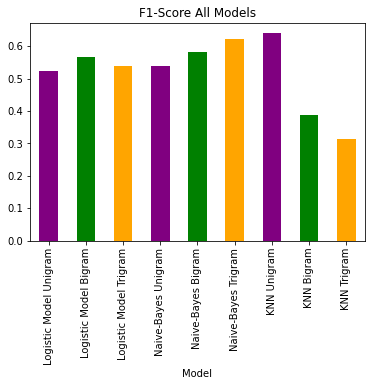

In [122]:
# Plot F1 score of all models.
df_all_models.plot.bar(x='Model',y='F1-Score',color=['purple','green','orange'],title='F1-Score All Models',legend=False)

# Limitations and Biases

In [ ]:
INSERT LIMITATIONS HERE.

Training and serving skew. We see that our training dataset is heavily biased with one or two works yielding high accuracy. We pulled in a second dataset to run our model against. Interestingly the Bi and Trigrams in KNN are more performant with the Naive-Bayes Trigram. In other words, a more generalized model seemed to work better when testing with a second dataset

# Next Steps

In [ ]:
INSERT NEXT STEPS HERE.